Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 



# Table of Contents


* **Geting Started**
* **Tuning**

# Getting Started

In this notebook, we'll see how to do find the best potential hyper-parameters for a given model via the **`ModelTuner`** class.

## Set Up Environment

In [1]:
# !pip install oolearning --upgrade

In [22]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

## Import Data

`ExploreClassificationDataset` is a convenience class described in the [first notebook of this series](https://github.com/shane-kercheval/oo-learning/blob/master/examples/classification-titanic/1-Exploring%20the%20Titanic%20Dataset.ipynb).

In [3]:
csv_file = '../data/titanic.csv'
target_variable = 'Survived'
target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable,
                                                map_numeric_target=target_mapping)

In [4]:
explore.dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,lived,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,lived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,lived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Tuners

1) Split data into training and holdout sets

2) Use the Tuner to find the best hyper params

3) take the best hyper-params, refit on entire training set (via Trainer)

4) look at results


Make a note that since the Trainer uses the same splitter, the Trainer will use the same training/holdout sets as when we manually split th edata


## Split Data

First, let's split the data into training/holdout sets, so that we can find the best Hyper-Parameters on the training set and then evaluate on the holdout set.

However, we'll actually ignore the holdout indexes, since we will use a Trainer to do the work for us of refitting the final model on the training data and predicting/evaluating on the holdout data. If we use the same splitter in the Trainer, the split will be the same (i.e. same training data used in the Tuner will be used to refit the final model).

In [5]:
splitter = ClassificationStratifiedDataSplitter(holdout_ratio=0.20)  # set aside 20% of the data for the holdout set
training_indexes, _ = splitter.split(target_values=explore.dataset.Survived)  # ignore holdout indexes

In [6]:
training_y = explore.dataset.iloc[training_indexes][target_variable]
training_x = explore.dataset.iloc[training_indexes].drop(columns=target_variable)
training_x.shape

(712, 11)

In [7]:
training_y.value_counts(normalize=True)

died     0.616573
lived    0.383427
Name: Survived, dtype: float64

## Find Best Hyper-Params via Tuner

Now, let's use a **`ModelTuner`** object to search for best hyper-parameters for a given model. 

The `ModelTuner` uses a `Resampler` (along with `Scores`) in order evaluate the performance of each model/hyper-parameter-set used, and compare the performance across all hyper-paremeter combinations used. 

In [8]:
# define the transformations
transformations = [RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
                   CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                   ImputationTransformer(),
                   DummyEncodeTransformer(CategoricalEncoding.ONE_HOT)]

# define the scores, which will be used to compare the performance across hyper-param combinations
# the scores need a Converter, which contains the logic necessary to convert the predicted values to a predicted class.
evaluator_list = [AucRocScore(positive_class='lived'),
                  SensitivityScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived')),
                  SpecificityScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived')),
                  ErrorRateScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived'))]

# define/configure the resampler
resampler = RepeatedCrossValidationResampler(model=RandomForestClassifier(),  # using a Random Forest model
                                             transformations=transformations,
                                             scores=evaluator_list,
                                             folds=5,
                                             repeats=5,
                                             fold_decorators=[TwoClassThresholdDecorator()])
# define/configure the ModelTuner
tuner = ModelTuner(resampler=resampler,
                   hyper_param_object=RandomForestHP())  # Hyper-Parameter object specific to RF


We need to define the combinations of hyper-parameters we want to try out and evalaute.

We'll use a dictionary and a **`HyperParamsGrid`** object to do this.

We'll also need to know how many columns of the model is expecting, so that we can guess reasonable defaults for `max_features`. To do this, we'll peak at the data with `TransformerPipeline.get_expected_columns()`.

In [21]:
# get the expected columns at the time we do the training, based on the transformations 
columns = TransformerPipeline.get_expected_columns(transformations=transformations, data=training_x)

# define the combinations of hyper-params that we want to evaluate
params_dict = dict(criterion='gini',
                   max_features=[int(round(len(columns) ** (1 / 2.0))),
                                 int(round(len(columns) / 2)),
                                 len(columns)],
                   n_estimators=[10, 100, 500],
                   min_samples_leaf=[1, 50, 100])
grid = HyperParamsGrid(params_dict=params_dict)

We'll pass the **`HyperParamsGrid`** to the tuner, which will tell the tuner which combinations of hyper-params to try. We can preview the combinations with **`.params_grid()`**

In [10]:
grid.params_grid

,criterion,max_features,n_estimators,min_samples_leaf
0,gini,5,10,1
1,gini,5,10,50
2,gini,5,10,100
3,gini,5,100,1
4,gini,5,100,50
5,gini,5,100,100
6,gini,5,500,1
7,gini,5,500,50
8,gini,5,500,100
9,gini,12,10,1


## Train Best Hyper-Params on Full Training, Predict on Holdout

In [11]:
tuner.tune(data_x=training_x, data_y=training_y, params_grid=grid)

## Evaluate

In [12]:
tuner.results.tune_results

,criterion,max_features,n_estimators,min_samples_leaf,AUC_ROC_mean,AUC_ROC_st_dev,AUC_ROC_cv,sensitivity_mean,sensitivity_st_dev,sensitivity_cv,specificity_mean,specificity_st_dev,specificity_cv,error_rate_mean,error_rate_st_dev,error_rate_cv
0,gini,5,10,1,0.836727,0.033050,0.04,0.683692,0.068438,0.10,0.849635,0.032368,0.04,0.214658,0.030587,0.14
1,gini,5,10,50,0.839121,0.032363,0.04,0.594860,0.120593,0.20,0.886069,0.052818,0.06,0.227569,0.038521,0.17
2,gini,5,10,100,0.829799,0.033664,0.04,0.529441,0.115089,0.22,0.930153,0.069108,0.07,0.226323,0.036085,0.16
3,gini,5,100,1,0.850099,0.028183,0.03,0.704866,0.073525,0.10,0.854431,0.034844,0.04,0.203374,0.027248,0.13
4,gini,5,100,50,0.845754,0.032071,0.04,0.686762,0.069028,0.10,0.852154,0.038659,0.05,0.210773,0.033124,0.16
5,gini,5,100,100,0.837468,0.031980,0.04,0.633867,0.070297,0.11,0.872679,0.048712,0.06,0.219898,0.030820,0.14
6,gini,5,500,1,0.851228,0.027524,0.03,0.704995,0.074236,0.11,0.852797,0.034690,0.04,0.204401,0.026252,0.13
7,gini,5,500,50,0.847051,0.030929,0.04,0.680919,0.071235,0.10,0.853712,0.040170,0.05,0.212531,0.033476,0.16
8,gini,5,500,100,0.836300,0.032829,0.04,0.558825,0.074824,0.13,0.904944,0.044586,0.05,0.229086,0.030968,0.14
9,gini,12,10,1,0.845656,0.026065,0.03,0.698784,0.064051,0.09,0.858848,0.036255,0.04,0.202962,0.029586,0.15


In [13]:
tuner.results.time_results

,criterion,max_features,n_estimators,min_samples_leaf,execution_time
0,gini,5,10,1,125 seconds
1,gini,5,10,50,124 seconds
2,gini,5,10,100,122 seconds
3,gini,5,100,1,126 seconds
4,gini,5,100,50,141 seconds
5,gini,5,100,100,126 seconds
6,gini,5,500,1,158 seconds
7,gini,5,500,50,141 seconds
8,gini,5,500,100,137 seconds
9,gini,12,10,1,131 seconds


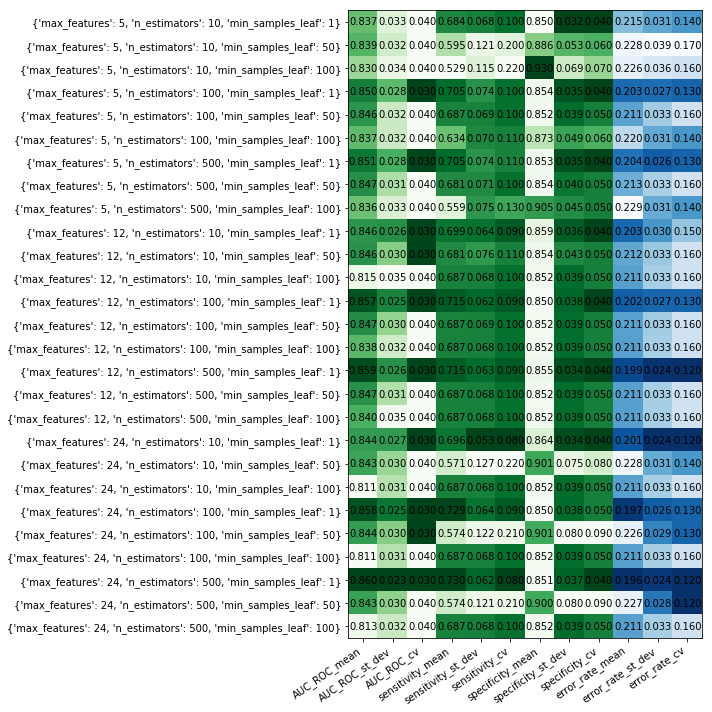

In [14]:
tuner.results.get_heatmap()

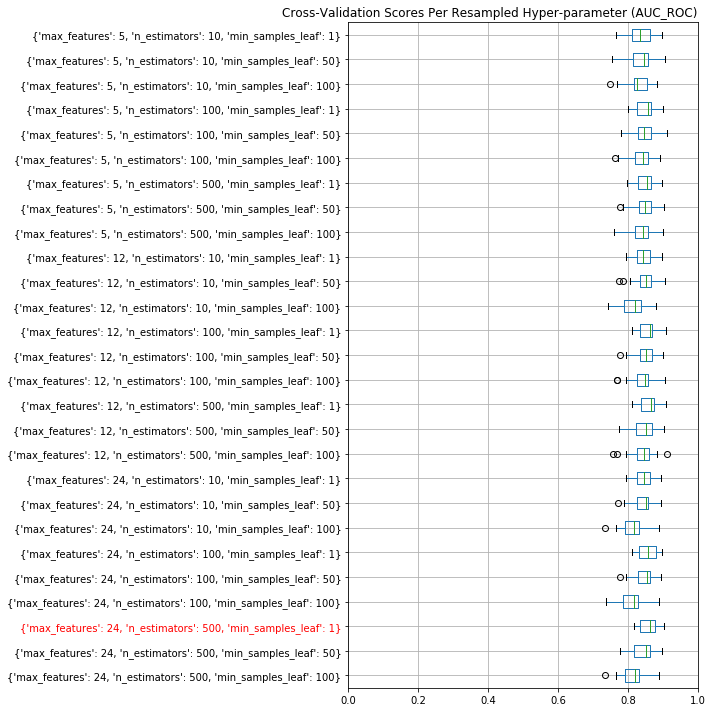

In [15]:
tuner.results.get_cross_validation_boxplots(metric=Metric.AUC_ROC)

In [16]:
tuner.results.best_model

criterion             gini     
max_features          24       
n_estimators          500      
min_samples_leaf      1        
AUC_ROC_mean          0.85986  
AUC_ROC_st_dev        0.0227851
AUC_ROC_cv            0.03     
sensitivity_mean      0.730049 
sensitivity_st_dev    0.0615761
sensitivity_cv        0.08     
specificity_mean      0.850569 
specificity_st_dev    0.0371165
specificity_cv        0.04     
error_rate_mean       0.19591  
error_rate_st_dev     0.0242067
error_rate_cv         0.12     
Name: 24, dtype: object

In [17]:
tuner.results.best_hyper_params

{'criterion': 'gini',
 'max_features': 24,
 'min_samples_leaf': 1,
 'n_estimators': 500}

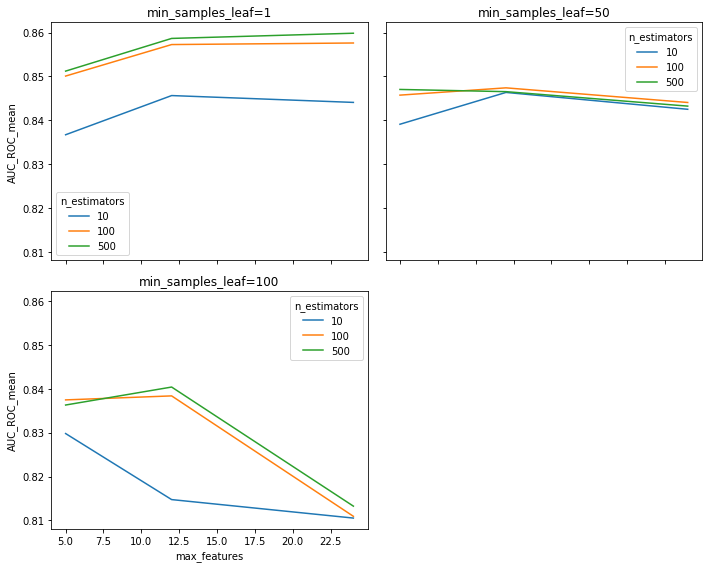

In [18]:
tuner.results.get_profile_hyper_params(metric=Metric.AUC_ROC,
                                       x_axis='max_features',
                                       line='n_estimators',
                                       grid='min_samples_leaf')

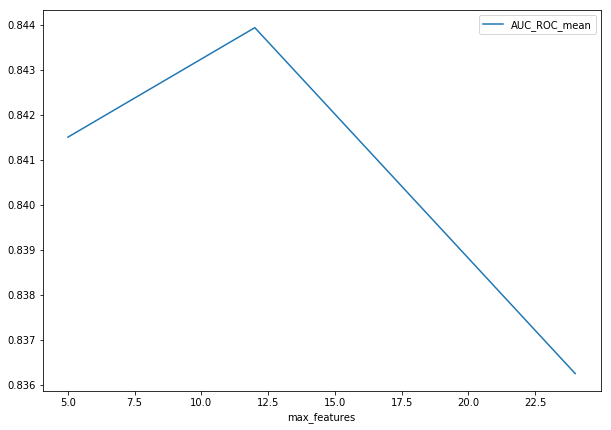

In [19]:
tuner.results.get_profile_hyper_params(metric=Metric.AUC_ROC, x_axis='max_features')

In [24]:
# best_index is the associated with the best model's hyper-parameters
best_decorator = tuner.results.resampler_decorators_first[tuner.results.best_index]
calculated_resampled_threshold = best_decorator.roc_ideal_thresholds_mean
calculated_resampled_threshold

0.4599999999999999

# Retrain & Predict

After finding the best hyper-parameters, we want to etrain the hyper-parameters on the full training set and predict/evaluate on the holdout set.

As stated previously, since we'll use same type of splitter in the `ModelTrainer`, the training/holdout split will be the same (i.e. same training indexes/data used in the Tuner from the manual split will be used to refit the final model).

Note, instead of using the default threshold of `0.5`, we'll use the threshold calculated by the resampler (associated with the hyper-parameters we are choosing), that makes the best tradeoff between Sensitivity/Specificity, captured via **`calculated_resampled_threshold`**.

In [30]:
# define how we want to split the training/holding datasets
splitter = ClassificationStratifiedDataSplitter(holdout_ratio=0.2)

# define the transformations
transformations = [RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
                   CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                   ImputationTransformer(),
                   DummyEncodeTransformer(CategoricalEncoding.ONE_HOT)]

# Define how we want to evaluate (and convert the probabilities DataFrame to predicted classes)
evaluator = TwoClassProbabilityEvaluator(converter=
                                         TwoClassThresholdConverter(threshold=calculated_resampled_threshold,
                                                                    positive_class='lived'))

# give the objects, which encapsulate the behavior of everything involved with training the model, to our ModelTrainer
trainer = ModelTrainer(model=RandomForestClassifier(),
                       model_transformations=transformations,
                       splitter=splitter,
                       evaluator=evaluator)

Let's define the hyper-parameters we want to use.

We know we want to use the **`RandomForestHP`** class, but we also know that for some of the possible hyper-parameters to use, we'll want to update a few with the values we found with our `ModelTuner`.

Let's first define our object, and use **`.params_dict`** to see the default parameters and values.

In [28]:
rf_hyper_params = RandomForestHP()
rf_hyper_params.params_dict

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'oob_score': False}

Now let's update the specific parameters that we found with the Tuner (which we can access via **`tuner.results.best_hyper_params`**).

We can use **`.update_dict()`**, which conveniently takes a dictionary with the parameter names/values that we want to update (which is what `best_hyper_params will return`) and updates the corresponding values of the hyper-parameters.

In this case, the only parameter that will actually change is `max_features`; the other parameters have values that are the same as the defaults.

In [29]:
rf_hyper_params.update_dict(tuner.results.best_hyper_params)
rf_hyper_params.params_dict

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 24,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'oob_score': False}

In [31]:
trainer.train(data=explore.dataset, target_variable='Survived', hyper_params=rf_hyper_params)

In [32]:
# access the holdout metrics (we also have `training_evaluator` available to us as well!) and get a summary
trainer.holdout_evaluator.all_quality_metrics

{'AUC Precision/Recall': 0.7693830218733662,
 'AUC ROC': 0.8198945981554676,
 'Error Rate': 0.19553072625698323,
 'F1 Score': 0.7407407407407408,
 'False Negative Rate': 0.2753623188405797,
 'False Positive Rate': 0.14545454545454545,
 'Kappa': 0.583914458391446,
 'Negative Predictive Value': 0.831858407079646,
 'No Information Rate': 0.6145251396648045,
 'Positive Predictive Value': 0.7575757575757576,
 'Prevalence': 0.3854748603351955,
 'Total Observations': 179,
 'True Negative Rate': 0.8545454545454545,
 'True Positive Rate': 0.7246376811594203,
 'Two-Class Accuracy': 0.8044692737430168}

Note: the threshold used in the Score to evaluate the performances was 0.5, rather than using the decorators that find the "ideal" threshold. IMO, in general, it is better to use metrics like AUC that doesn't depend on the ROC (or Precision-Recall) tradeoffs, and then once the best model is found based on AUC, determine how you want to make tradeoffs based on your particular situation/problem

(reword)